In [1]:
# !pip3 uninstall -y afc
# !pip3 install ../..
# !pip install git+https://github.com/LBNL-ETA/AFC@v0.0.1

In [2]:
import os
import sys
import time
import json
import pandas as pd
import datetime as dtm
import multiprocessing as mp
import matplotlib.pyplot as plt

from io import StringIO

try:
    root = os.path.dirname(os.path.abspath(__file__))
except:
    root = os.getcwd()
    
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

from afc.radiance import forecast as forecast
from afc.radiance import configs as mpc_config
from afc.utility.weather import read_tmy3
from worker_radiance import worker

WANRNING: Did not load emulator
cannot import name 'radmtx' from 'frads' (/usr/local/lib/python3.10/dist-packages/frads/__init__.py)


### Configuration

In [3]:
cpus = mp.cpu_count()-1
st = dtm.datetime(2021, 12, 25) # Sunny day solstice
horizon = 24 # hours
frads_version = 'new'
# res_old_name = '20240111T041118-old-compare.json'
res_old_name = '20240124T192443-old-compare.json'

control = {'ec': {}, 'dshade': {}, 'shade': {}, 'blinds': {}}
control['ec'] = {'dark': [int(0), int(0), int(0)], 'bright': [int(2), int(2), int(2)], 'clear': [int(3), int(3), int(3)],
                 'refup': [int(0), int(0), int(2)], 'refdn': [int(2), int(0), int(0)]}
control['dshade'] = {'dark': [int(0), int(0), int(0)], 'bright': [int(2), int(1), int(0)], 'clear': [int(2), int(2), int(2)],
                     'refup': [int(2), int(2), int(2)], 'refdn': [int(1), int(0), int(0)]}
control['shade'] = control['dshade']
control['blinds'] = {'dark': [int(0), int(0), int(0)], 'bright': [int(1), int(0), int(1)], 'clear': [int(1), int(1), int(1)],
                     'refup': [int(0), int(0), int(2)], 'refdn': [int(2), int(0), int(0)]}

### Weather Data

In [4]:
weather_path = os.path.join(root, '..', 'resources', 'weather', 
    'USA_CA_San.Francisco.Intl.AP.724940_TMY3.csv')
weather, info = read_tmy3(weather_path, coerce_year=st.year)
weather = weather.resample('5T').interpolate()
wf = weather.loc[st:st+pd.DateOffset(hours=horizon), ['dni', 'dhi']].copy()

### Simulate

In [5]:
jobs = []
for mode in ['ec', 'dshade', 'shade', 'blinds']:
    for wwr in [0.6, 0.4]:
        
        # initialize radiance (first run)
        print(f'===> Compiling Matrices for {wwr} WWR for "{mode}".')
        facade_type = mode
        if mode == 'dshade':
            facade_type = 'shade'
        filestruct_mpc, config_path_mpc = mpc_config.get_config(mode, str(wwr))
        forecaster = forecast.Forecast(config_path_mpc,
                                       regenerate=False,
                                       facade_type=facade_type,
                                       filestruct=filestruct_mpc)
        
        for ctrl_mode in ['dark', 'bright', 'clear', 'refup', 'refdn']:
            jobs.append([wf, mode, wwr, ctrl_mode, control[mode][ctrl_mode]])

===> Compiling Matrices for 0.6 WWR for "ec".
===> Compiling Matrices for 0.4 WWR for "ec".
===> Compiling Matrices for 0.6 WWR for "dshade".
===> Compiling Matrices for 0.4 WWR for "dshade".
===> Compiling Matrices for 0.6 WWR for "shade".
===> Compiling Matrices for 0.4 WWR for "shade".
===> Compiling Matrices for 0.6 WWR for "blinds".
===> Compiling Matrices for 0.4 WWR for "blinds".


In [6]:
print('Running {} jobs on {} cores...'.format(len(jobs), cpus))
st = time.time()
with mp.Pool(cpus) as p:
    data = p.map(worker, jobs)
res = {}
for r in data:
    res.update(r)
print('Done after {} min.'.format(round((time.time()-st)/60, 1)))

Running 40 jobs on 15 cores...
Done after 4.3 min.


In [7]:
with open(os.path.join(root, res_old_name)) as f:
    res_old = {k:pd.read_csv(StringIO(v), index_col=0) for k,v in json.loads(f.read()).items()}
for k in res_old:
    res_old[k].index = pd.to_datetime(res_old[k].index)

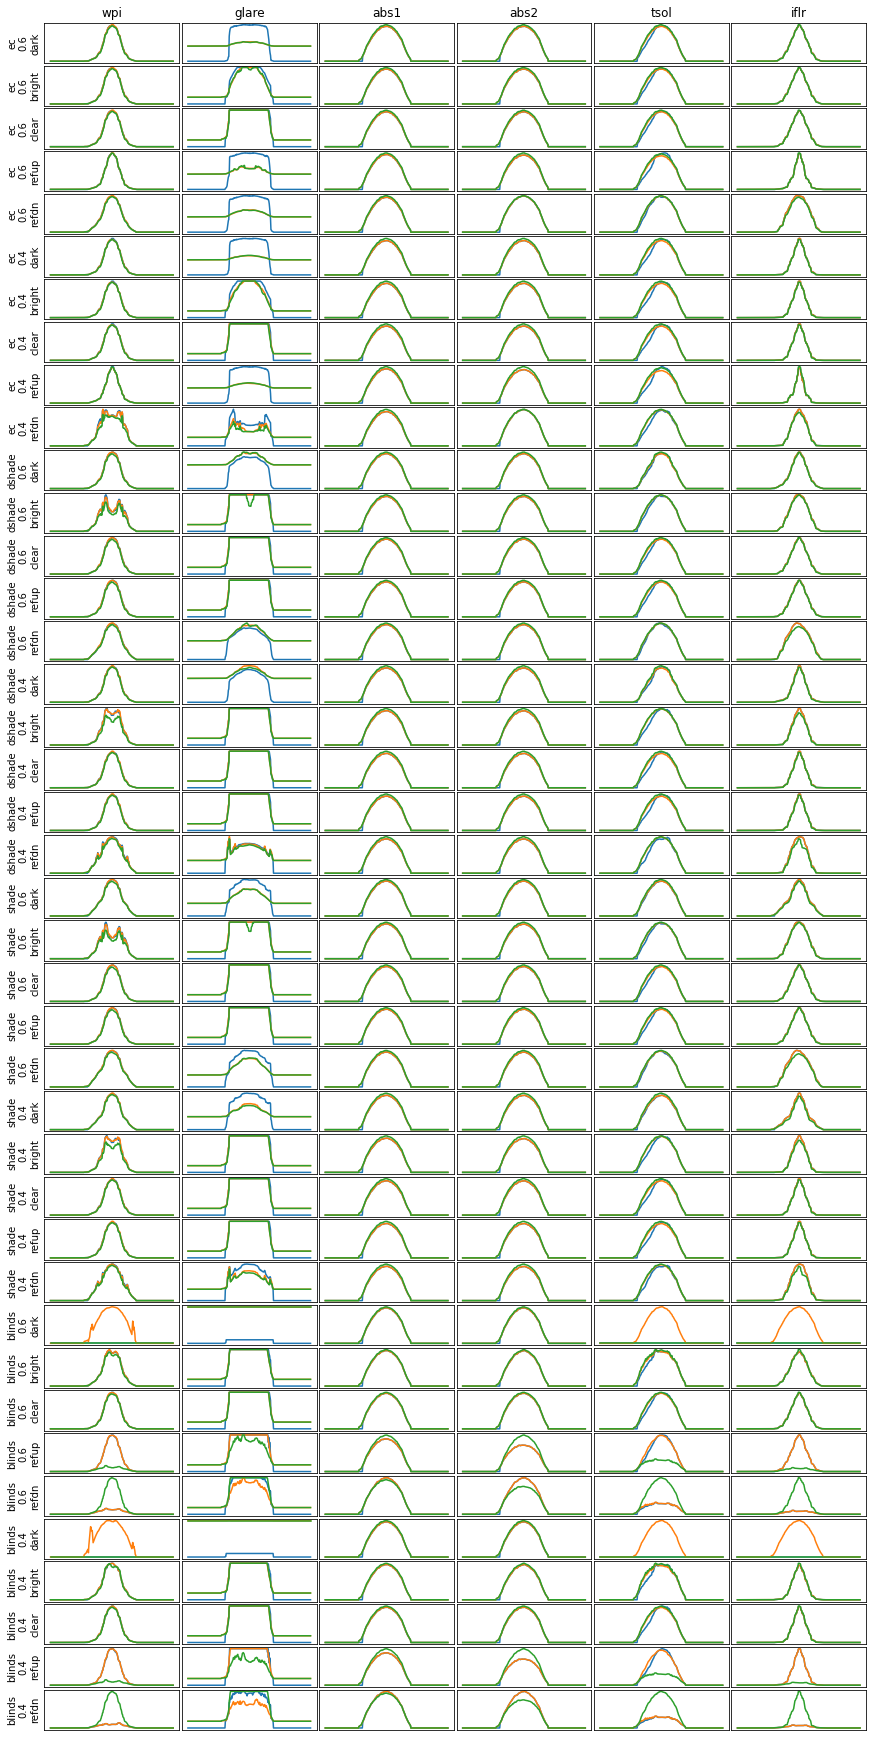

In [8]:
figs = [['emu_wpi','ctrl_wpi'],
        ['emu_glare','ctrl_glare_lim'],
        ['emu_abs1','ctrl_abs1'],
        ['emu_abs2','ctrl_abs2'],
        ['emu_tsol','ctrl_tsol'],
        ['emu_iflr','ctrl_iflr']]

fig, axs = plt.subplots(len(res),len(figs), figsize=(12, 6*4), sharex=False, sharey=False)
axs = axs.ravel()

for i, k in enumerate(res.keys()):
    for ii, f in enumerate(figs):
        ax = i*len(figs)+ii
        if frads_version == 'new':
            axs[ax].plot(res_old[k][f])
        axs[ax].plot(res[k][[c for c in f if c in res[k].columns]])
        axs[ax].set_xticks([])
        axs[ax].set_yticks([])
        if i == 0:
            axs[ax].set_title(f[0].split('_')[1])
        if ii == 0:
            axs[ax].set_ylabel(k.replace('-', '\n'))

plt.tight_layout(pad=0.25)
plt.savefig('test.jpg')
plt.show()

In [9]:
with open(os.path.join(root, dtm.datetime.now().strftime(f'%Y%m%dT%H%M%S-{frads_version}-compare.json')), 'w') as f:
    f.write(json.dumps({k:v.to_csv() for k,v in res.items()}))

In [10]:
# with open(os.path.join(root, '20240124T192443-old-compare.json')) as f:
#     res1 = {k:pd.read_csv(StringIO(v), index_col=0) for k,v in json.loads(f.read()).items()}
# for k in res1:
#     res1[k].index = pd.to_datetime(res1[k].index)

# with open(os.path.join(root, '20240124T214249-old-compare.json')) as f:
#     res2 = {k:pd.read_csv(StringIO(v), index_col=0) for k,v in json.loads(f.read()).items()}
# for k in res2:
#     res2[k].index = pd.to_datetime(res2[k].index)

In [11]:
# figs = [['emu_wpi','ctrl_wpi'],
#         ['emu_abs1','ctrl_abs1'],
#         ['emu_abs2','ctrl_abs2'],
#         ['emu_iflr','ctrl_iflr']]

# keys = ['dshade-0.6-dark', 'dshade-0.6-bright', 'dshade-0.6-clear',
#         'dshade-0.4-dark', 'dshade-0.4-bright', 'dshade-0.4-clear']

# fig, axs = plt.subplots(len(figs),len(keys), figsize=(12, 6), sharex=True, sharey='row')
# axs = axs.ravel()

# for i, f in enumerate(figs):
#     for ii, k in enumerate(keys):
#         ax = i*len(keys)+ii
#         axs[ax].plot(res[k][f])
#         axs[ax].set_xticks([])
#         #axs[ax].set_yticks([])
#         if i == 0:
#             axs[ax].set_title(k.replace('-', '\n'))
#         if ii == 0:
#             axs[ax].set_ylabel(f[0].split('_')[1])

# plt.tight_layout(pad=0.25)
# plt.show()